(Just as a warning, this takes about an hour to run)

In [29]:
import pandas as pd
import pulp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
# COAST, NCENT, NORTH, SCENT, SOUTH, WEST, EAST, FWEST
REGION = 'FWEST'
RATING = 500
CAPACITY = 700

In [31]:
def pulp24hrBattery(pred_load, actual_load, RATING, CAPACITY):
    model = pulp.LpProblem("Daily demand charge minimization problem", pulp.LpMinimize)
    power = pulp.LpVariable.dicts("ChargingPower", range(24))

    for i in range(24):
        power[i].lowBound = 0
        power[i].upBound = RATING
    pDemand = pulp.LpVariable("Peak Demand", lowBound=0)

    model += pDemand

    for i in range(24):
        model += pDemand >= pred_load[i] - power[i]    
    model += pulp.lpSum(power) <= CAPACITY
    
    model.solve()
    return [actual_load[i] - power[i].varValue for i in range(24)]

def optimal_daily(day_load, RATING, CAPACITY):
    ps = max(day_load)
    new_load = list(day_load)
    broken = True
    while broken:
        ps -= 1
        new_load = [ps if l > ps else l for l in new_load]
        diff = [p - l for p, l in zip(day_load, new_load)]
        broken = sum(diff) <= CAPACITY and all([d <= RATING for d in diff])    
    return new_load

In [33]:
d = {}

REGIONS = ['COAST', 'NCENT', 'NORTH', 'SCENT', 'SOUTH', 'WEST', 'EAST', 'FWEST']

for region in REGIONS:
    d[region] = {}
    df = pd.read_csv('data/' + region + '.csv', parse_dates=['dates'])
    df = df.drop('tempc', axis=1)
    
    m = df['load'].tolist()
    load_24 = [m[i: i+24] for i in range(0, len(m), 24)]
    d[region]['max_load'] = df.groupby(df.dates.dt.date)['load'].max().sum()
    for error in range(0, 6):
        error = float(error) / 100
        
        df['prediction'] = df['load'].apply(lambda x: x + np.random.normal(0, error*x))
        m = df['prediction'].tolist()
        pred_24 = [m[i: i+24] for i in range(0, len(m), 24)]
        
        n_load = []
        for pred_load, actual_load in zip(pred_24, load_24):
            n_load.append(pulp24hrBattery(pred_load, actual_load, RATING, CAPACITY))
        
        NEW_MAX_LOAD = sum([max(d) for d in n_load])
        
        d[region][str(error)] = NEW_MAX_LOAD

In [34]:
d

{'COAST': {'max_load': 77721649.66037036,
  '0.0': 75809251.74459507,
  '0.01': 76498169.77752419,
  '0.02': 76950752.65908948,
  '0.03': 77171724.08705083,
  '0.04': 77312090.39290236,
  '0.05': 77399683.99228221},
 'NCENT': {'max_load': 93773648.6918708,
  '0.0': 91533628.70877777,
  '0.01': 92237450.84304467,
  '0.02': 92730368.15890302,
  '0.03': 92978300.61397263,
  '0.04': 93150302.64848043,
  '0.05': 93261501.92186493},
 'NORTH': {'max_load': 7130208.749295982,
  '0.0': 6349085.322981104,
  '0.01': 6451080.715124064,
  '0.02': 6549544.0250006495,
  '0.03': 6640684.186158286,
  '0.04': 6719267.414633589,
  '0.05': 6787450.973172543},
 'SCENT': {'max_load': 46552652.39863016,
  '0.0': 44749910.964965664,
  '0.01': 45193353.983446315,
  '0.02': 45556491.24291853,
  '0.03': 45807295.68398681,
  '0.04': 45991584.24820465,
  '0.05': 46103072.62559226},
 'SOUTH': {'max_load': 21828290.2829737,
  '0.0': 20556240.387334883,
  '0.01': 20811960.18713641,
  '0.02': 21045330.147723798,
  '0.

In [63]:
d_p = {}

translate = {
    '0.0': '0',
    '0.01': '1',
    '0.02': '2',
    '0.03': '3',
    '0.04': '4',
    '0.05': '5',
    'max_load': 'max_load'
}

for region, results in d.items():
    d_p[region] = {}
    MAX_SHAVE = results['max_load'] - results['0.0']
    for p, r in d[region].items():
        d_p[region][translate[p]] = round((results['max_load'] - d[region][p]) / MAX_SHAVE * 100, 2)

In [64]:
df_p = pd.DataFrame().from_dict(d_p)
df_p = df_p.drop('max_load', axis=0)

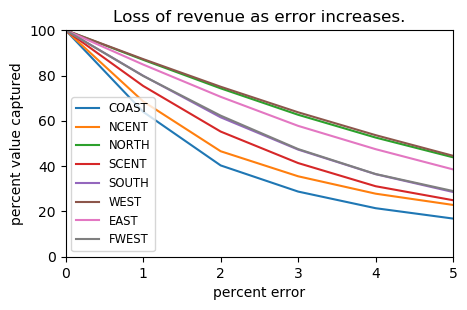

In [73]:
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')

fig, ax = plt.subplots(figsize=(5, 3), dpi=100)
df_p.plot(ax=ax)
ax.set_ylim(0, 100)
ax.set_xlabel('percent error')
ax.set_ylabel('percent value captured')
ax.set_title('Loss of revenue as error increases.')
ax.legend(prop=fontP) 

In [74]:
import json
with open('error_effect.json', 'w') as f:
    json.dump(d, f, indent=4)